In [18]:
import pandas as pd
import numpy as np
import requests

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

r = requests.get(uri)
with open('dados/simulacao-caros.csv', 'wb') as f:
    f.write(r.content)


dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [19]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [20]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [49.79, 53.45]


In [21]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [22]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [23]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [24]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [25]:
# GroupKFold para analisar como o modelo se comporta com novos grupos


SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


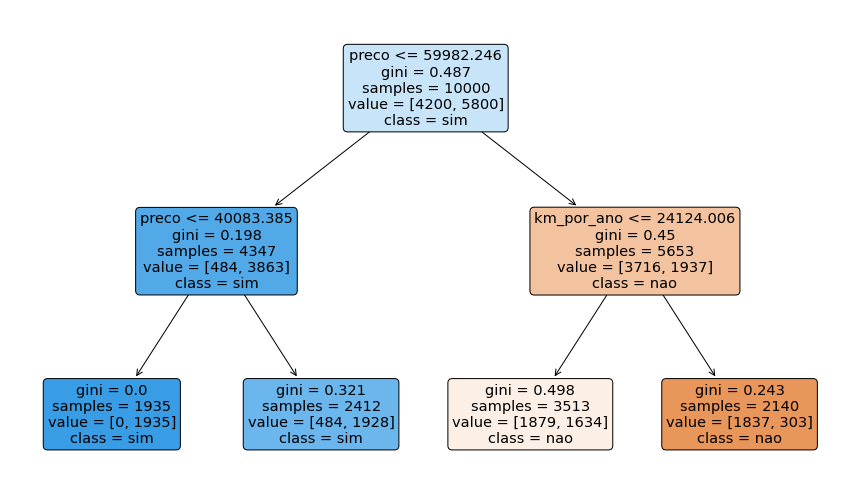

In [26]:
# Plotando arvore de decisão

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

modelo.fit(x_azar, y_azar)

plt.figure(figsize=(15,9))
plot_tree(modelo, feature_names=x_azar.columns, filled=True, class_names=['nao', 'sim'], rounded=True)
plt.show()

In [27]:
# Utilizando 3 graus de profundidade

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


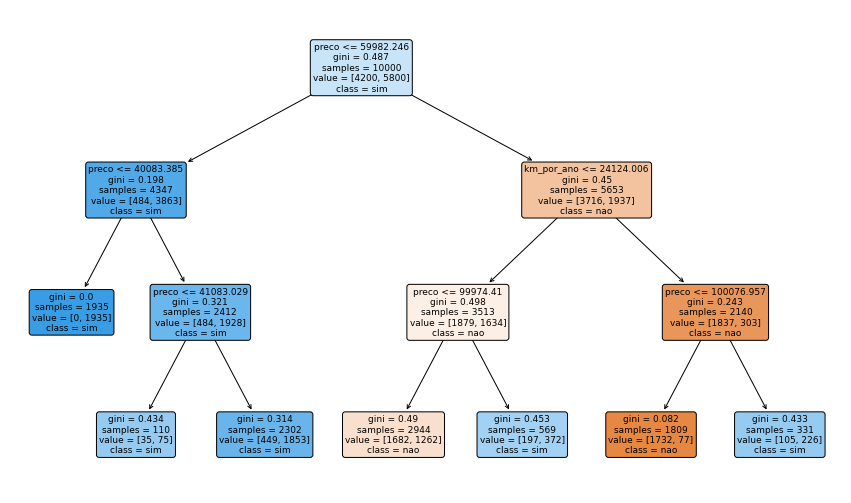

In [28]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

modelo.fit(x_azar, y_azar)

plt.figure(figsize=(15,9))
plot_tree(modelo, feature_names=x_azar.columns, filled=True, class_names=['nao', 'sim'], rounded=True)
plt.show()

# Explorando hiperparametros em 1 dimensão

In [29]:
def avalia_profundidade(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    media_teste = results['test_score'].mean()
    media_treino = results['train_score'].mean()
    print(f'Modelo max_depth = {max_depth}, treino = {media_treino*100:0.2f}, teste = {media_teste*100:0.2f} ')
    return [max_depth, media_treino, media_teste]

resultados = [avalia_profundidade(i) for i in range(1, 33)]
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'train_score', 'test_score'])

Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.79, teste = 78.63 
Modelo max_depth = 5, treino = 78.94, teste = 78.56 
Modelo max_depth = 6, treino = 79.17, teste = 78.12 
Modelo max_depth = 7, treino = 79.50, teste = 77.96 
Modelo max_depth = 8, treino = 79.89, teste = 77.86 
Modelo max_depth = 9, treino = 80.46, teste = 77.38 
Modelo max_depth = 10, treino = 81.16, teste = 77.19 
Modelo max_depth = 11, treino = 82.03, teste = 76.97 
Modelo max_depth = 12, treino = 82.89, teste = 76.49 
Modelo max_depth = 13, treino = 83.95, teste = 75.81 
Modelo max_depth = 14, treino = 85.03, teste = 75.66 
Modelo max_depth = 15, treino = 86.14, teste = 75.16 
Modelo max_depth = 16, treino = 87.19, teste = 75.11 
Modelo max_depth = 17, treino = 88.31, teste = 74.74 
Modelo max_depth = 18, treino = 89.26, teste = 74.33 
Modelo max_depth = 19, treino = 90.32

In [30]:
resultados.head()

,max_depth,train_score,test_score
0,1,0.757912,0.757842
1,2,0.757912,0.757842
2,3,0.787510,0.786726
3,4,0.787876,0.786328
4,5,0.789410,0.785559


# OVERFIT: Perfeito para o treino, ruim para o teste

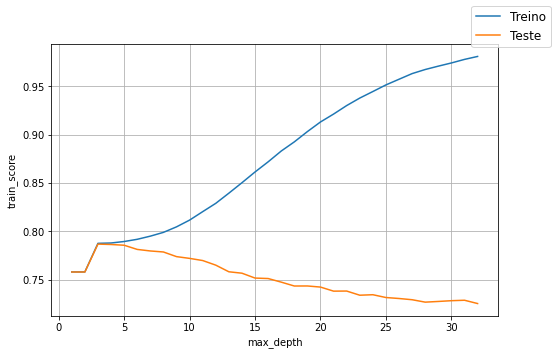

In [31]:
import seaborn as sns

fig = plt.figure(figsize=(8,5))
sns.lineplot(x = 'max_depth', y = 'train_score', data = resultados)
sns.lineplot(x = 'max_depth', y = 'test_score', data = resultados)
fig.legend(labels = [ 'Treino', 'Teste'], fontsize = 12)
plt.grid()

In [32]:
import plotly.graph_objects as go

trace1 = go.Scatter(x = resultados.max_depth, y = resultados.train_score, name = 'Treino', mode = 'lines')
trace2 = go.Scatter(x = resultados.max_depth, y = resultados.test_score, name = 'Teste', mode = 'lines')


layout = go.Layout(
    title = 'Acuracia do modelo',
    titlefont_size = 25,
    xaxis = dict(
        title = 'Profundiade',
        titlefont_size = 16
    ),
    yaxis = dict(
        title = 'Acurácia',
        titlefont_size = 16
    ),
    height = 600,
    width = 900
)
traces = [trace1, trace2]

go.Figure(traces, layout)

# Explorando hiperparametros em 2 dimensões

In [33]:
def avalia_profundidade(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf= min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    media_teste = results['test_score'].mean()
    media_treino = results['train_score'].mean()
    print(f'Modelo max_depth = {max_depth}, treino = {media_treino*100:0.2f}, teste = {media_teste*100:0.2f} ')
    tabela = [max_depth, min_samples_leaf, media_treino, media_teste]
    return tabela

resultados = [avalia_profundidade(i, j) for i in range(1, 33) for j in range(1, 33)]
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
resultados.head()

.81, teste = 76.26 
Modelo max_depth = 21, treino = 82.59, teste = 76.23 
Modelo max_depth = 21, treino = 82.45, teste = 76.14 
Modelo max_depth = 21, treino = 82.28, teste = 76.63 
Modelo max_depth = 21, treino = 82.19, teste = 76.39 
Modelo max_depth = 21, treino = 82.09, teste = 76.35 
Modelo max_depth = 21, treino = 81.95, teste = 76.22 
Modelo max_depth = 21, treino = 81.88, teste = 76.28 
Modelo max_depth = 21, treino = 81.70, teste = 76.65 
Modelo max_depth = 21, treino = 81.58, teste = 77.00 
Modelo max_depth = 21, treino = 81.50, teste = 76.95 
Modelo max_depth = 21, treino = 81.39, teste = 77.12 
Modelo max_depth = 21, treino = 81.28, teste = 77.09 
Modelo max_depth = 21, treino = 81.21, teste = 77.08 
Modelo max_depth = 21, treino = 81.14, teste = 77.06 
Modelo max_depth = 21, treino = 81.07, teste = 76.91 
Modelo max_depth = 21, treino = 80.98, teste = 77.18 
Modelo max_depth = 21, treino = 80.91, teste = 77.06 
Modelo max_depth = 21, treino = 80.88, teste = 76.92 
Modelo m

,max_depth,min_samples_leaf,train_score,test_score
0,1,1,0.757912,0.757842
1,1,2,0.757912,0.757842
2,1,3,0.757912,0.757842
3,1,4,0.757912,0.757842
4,1,5,0.757912,0.757842


In [34]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train_score,test_score
max_depth,1.000000,0.000000,0.681408,-0.522835
min_samples_leaf,0.000000,1.000000,-0.453825,0.528330
train_score,0.681408,-0.453825,1.000000,-0.762534
test_score,-0.522835,0.528330,-0.762534,1.000000


<AxesSubplot:>

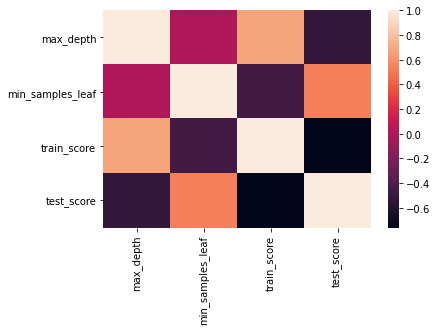

In [35]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train_score', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test_score', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train_score', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test_score', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train_score'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train_score'>,
        <AxesSubplot:xlabel='train_score', ylabel='train_score'>,
        <AxesSubplot:xlabel='test_score', ylabel='train_score'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test_score'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test_score'>,
        <AxesSubplot:xlabel='train_score', ylabel='tes

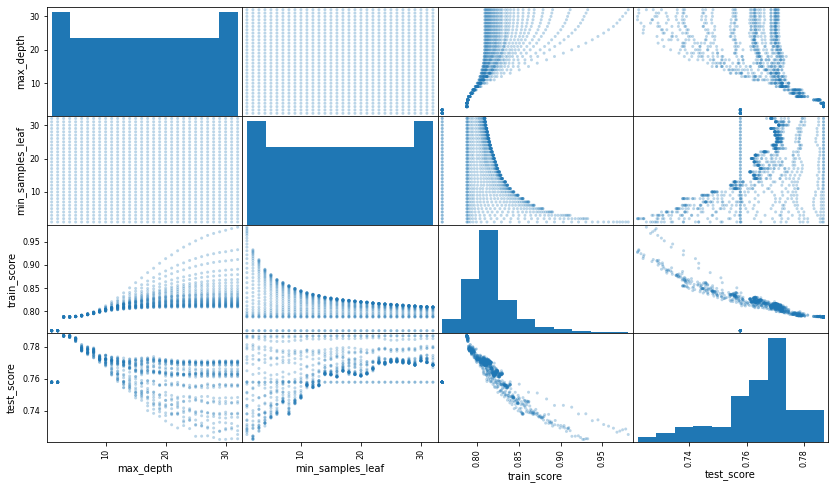

In [36]:
pd.plotting.scatter_matrix(resultados, figsize = (14,8), alpha = 0.3)

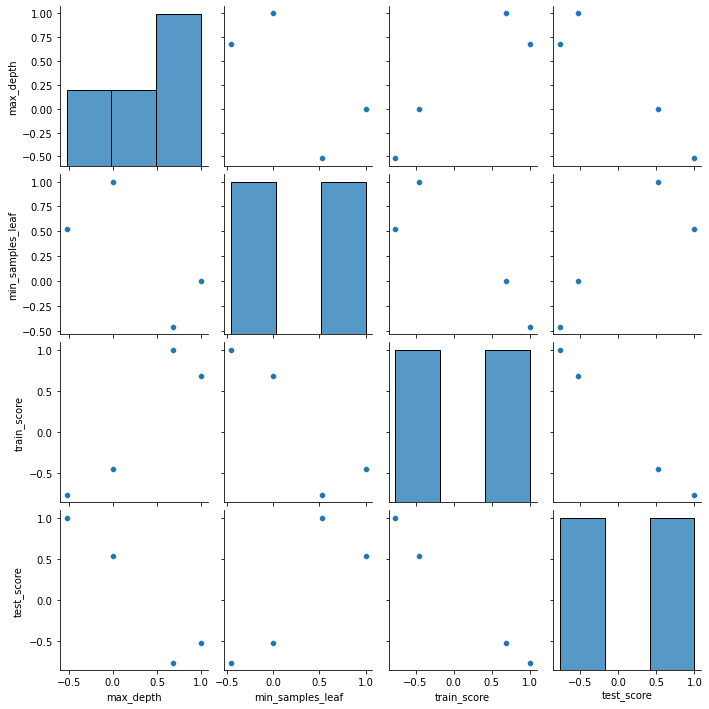

In [37]:
sns.pairplot(corr)

<AxesSubplot:>

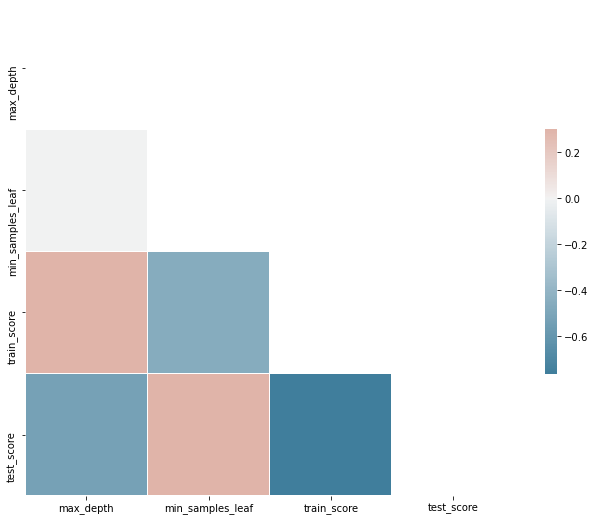

In [38]:
from string import ascii_letters

# sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [39]:
resultados.sort_values(by='test_score', ascending=False)

,max_depth,min_samples_leaf,train_score,test_score
123,4,28,0.787510,0.786726
126,4,31,0.787510,0.786726
85,3,22,0.787510,0.786726
84,3,21,0.787510,0.786726
83,3,20,0.787510,0.786726
...,...,...,...,...
865,28,2,0.923863,0.723310
961,31,2,0.930448,0.722575
993,32,2,0.932447,0.722532
929,30,2,0.928126,0.722147


In [40]:
def avalia_profundidade_e_min_leafs(min_leafs : list):
    resultados = [avalia_profundidade(i, j) for i in range(1, 33) for j in min_leafs]
    resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
    return resultados
resultados = avalia_profundidade_e_min_leafs([32,64,128,256])

Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 5, treino = 78.82, teste = 78.50 
Modelo max_depth = 5, treino = 78.79, teste = 78.45 
Modelo max_depth = 5, treino = 78.77, teste = 

In [41]:
corr = resultados.corr()

<AxesSubplot:>

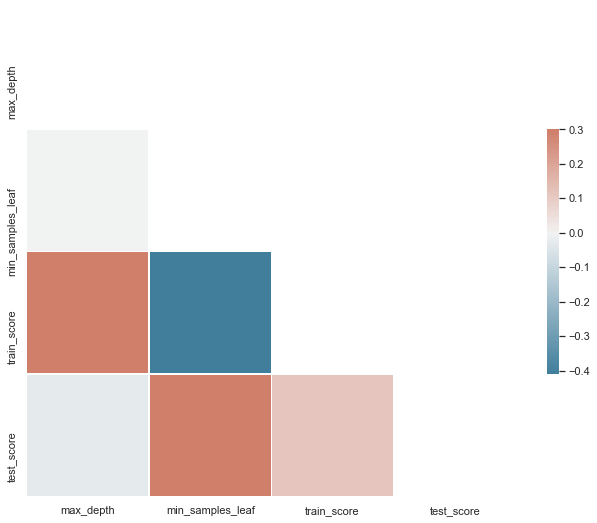

In [42]:
from string import ascii_letters

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [43]:
resultados.sort_values(by='test_score', ascending=False)[:5]

,max_depth,min_samples_leaf,train_score,test_score
15,4,256,0.78751,0.786726
12,4,32,0.78751,0.786726
14,4,128,0.78751,0.786726
13,4,64,0.78751,0.786726
8,3,32,0.78751,0.786726


Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 1, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 2, treino = 75.79, teste = 75.78 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 78.75, teste = 78.67 
Modelo max_depth = 3, treino = 77.53, teste = 77.50 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 78.75, teste = 78.67 
Modelo max_depth = 4, treino = 77.53, teste = 77.50 
Modelo max_depth = 5, treino = 78.77, teste = 78.44 
Modelo max_depth = 5, treino = 78.77, teste = 78.44 
Modelo max_depth = 5, treino = 78.77, teste = 

<AxesSubplot:>

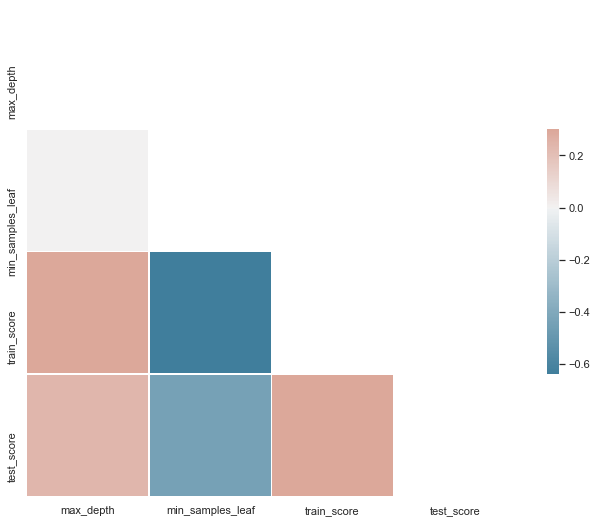

In [44]:
resultados = avalia_profundidade_e_min_leafs([128,192,256,512])
corr = resultados.corr()

from string import ascii_letters

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [45]:
resultados.sort_values(by='test_score', ascending=False)[:5]

,max_depth,min_samples_leaf,train_score,test_score
13,4,192,0.78751,0.786726
8,3,128,0.78751,0.786726
9,3,192,0.78751,0.786726
10,3,256,0.78751,0.786726
14,4,256,0.78751,0.786726


# Explorando 3 hiperparametros

In [46]:
def avalia_profundidade(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf= min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    media_teste = results['test_score'].mean()
    media_treino = results['train_score'].mean()
    tabela = [max_depth, min_samples_leaf, min_samples_split, media_treino, media_teste, fit_time, score_time]
    return tabela

def busca(min_leafs : list, min_splits : list):
    resultados = [avalia_profundidade(i, j, k) for i in range(1, 33) for j in min_leafs for k in min_splits]
    resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'min_samples_splot', 'train_score', 'test_score', 'fit_time', 'score_time'])
    return resultados

resultados = busca([32,64,128,256], [32,64,128,256])
resultados.head()

,max_depth,min_samples_leaf,min_samples_splot,train_score,test_score,fit_time,score_time
0,1,32,32,0.757912,0.757842,0.006199,0.002301
1,1,32,64,0.757912,0.757842,0.004700,0.002101
2,1,32,128,0.757912,0.757842,0.006897,0.002100
3,1,32,256,0.757912,0.757842,0.005101,0.002001
4,1,64,32,0.757912,0.757842,0.005298,0.001407


,max_depth,min_samples_leaf,min_samples_splot,train_score,test_score,fit_time,score_time
63,4,256,256,0.78751,0.786726,0.010399,0.001902
48,4,32,32,0.78751,0.786726,0.020799,0.004100
34,3,32,128,0.78751,0.786726,0.010999,0.001899
35,3,32,256,0.78751,0.786726,0.015499,0.003601
36,3,64,32,0.78751,0.786726,0.011899,0.002500


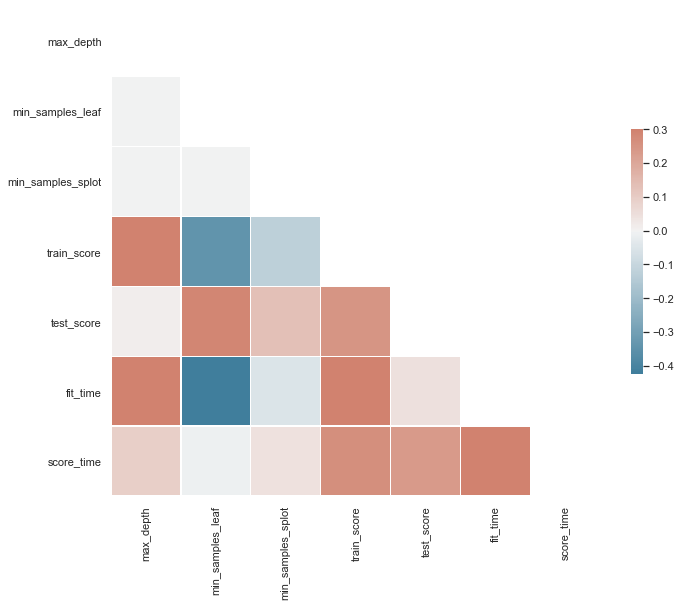

In [47]:
corr = resultados.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

resultados.sort_values(by='test_score', ascending=False)[:5]

# Explorando espaço de hiper parametros com GridSeachCV

In [48]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = dict(
    max_depth = [3,5],
    min_samples_leaf = [32,64,128],
    min_samples_split = [32,64,128],
    criterion = ['gini', 'entropy']

)

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016300,0.009584,0.0038,0.002086,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.012499,0.002202,0.0028,0.000872,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.011500,0.002157,0.0035,0.002907,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.010800,0.001400,0.0029,0.001222,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.011699,0.001847,0.0025,0.000923,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [49]:
print(busca.best_params_)
print(round(busca.best_score_*100, 2))



{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67


In [50]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [51]:
from sklearn.metrics import accuracy_score

# Evitar essa abordagem pois é muito otimista

predictions = melhor.predict(x_azar)
accuracy = accuracy_score(predictions, y_azar) * 100
print('Accuracy para os dados foi de %.2f%%' % accuracy)

Accuracy para os dados foi de 78.75%


# Como ter uma estimativa sem esse vicio nos dados que ja vi?
No caso de cross validations com busca de hiperparametros, fazemos uma nova validação cruzada. Chama-se nasted cross validation

In [52]:
from sklearn.model_selection import cross_val_score, KFold

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.782 , 0.784 , 0.791 , 0.781 , 0.7965])

In [53]:
def imprime_score(score):
  media = score.mean() * 100
  desvio = score.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
imprime_score(scores)

Accuracy médio 78.69
Intervalo [77.50, 79.88]


In [54]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


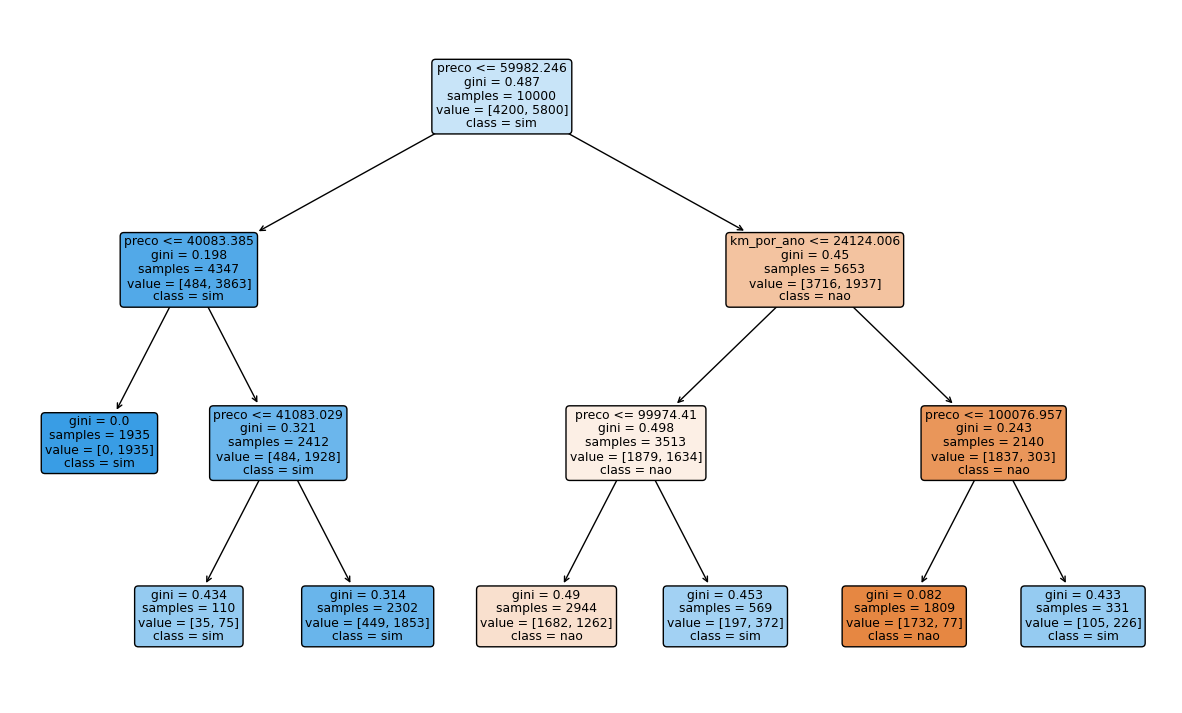

In [63]:
plt.style.use('default')


plt.figure(figsize=(15,9))
plot_tree(melhor, feature_names=x_azar.columns, filled=True, class_names=['nao', 'sim'], rounded=True)
plt.show()

# Busca aleatória: Random Search

In [98]:
from sklearn.model_selection import RandomizedSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = dict(
    max_depth = [3,5],
    min_samples_leaf = [32,64,128],
    min_samples_split = [32,64,128],
    criterion = ['gini', 'entropy']

)

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True),
                    n_iter=16)
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013399,0.002067,0.003001,0.000892,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.7755,0.7955,0.7895,0.7855,0.7740,0.7840,0.008210,12
1,0.013599,0.003074,0.002600,0.000489,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7755,0.8030,0.7895,0.7855,0.7815,0.7870,0.009241,1
2,0.012799,0.003312,0.003200,0.000980,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7755,0.8030,0.7895,0.7855,0.7815,0.7870,0.009241,1
3,0.018198,0.001472,0.002001,0.000002,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7755,0.7955,0.7895,0.7855,0.7755,0.7843,0.007859,7
4,0.017999,0.001549,0.002200,0.000980,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7755,0.7955,0.7895,0.7855,0.7755,0.7843,0.007859,7


In [74]:
scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=5), groups = dados.modelo)
imprime_score(scores)

Accuracy médio 78.57
Intervalo [76.98, 80.16]


DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)


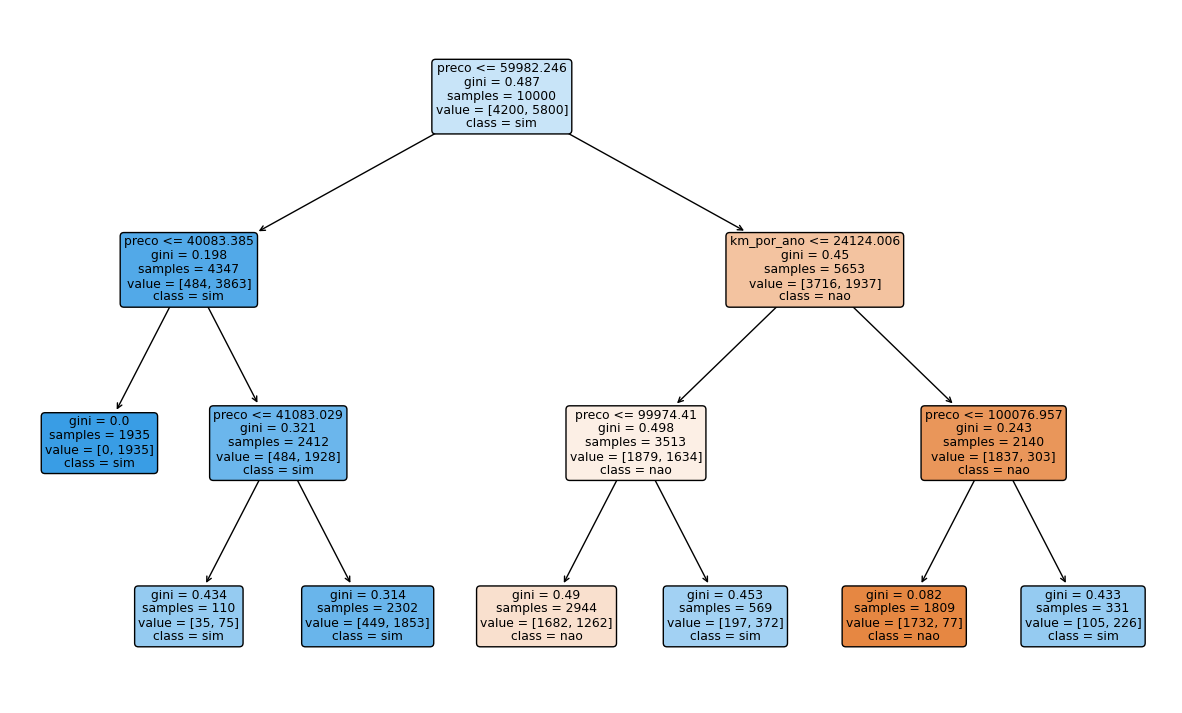

In [75]:
melhor = busca.best_estimator_
print(melhor)

plt.figure(figsize=(15,9))
plot_tree(melhor, feature_names=x_azar.columns, filled=True, class_names=['nao', 'sim'], rounded=True)
plt.show()

# Customizando espaço de hiper parametros

In [77]:
from scipy.stats import randint


SEED = 301
np.random.seed(SEED)

espaco_de_parametros = dict(
    max_depth = [3,5,10,15,20,25,30, None],
    min_samples_leaf = randint(32,128),
    min_samples_split = randint(32, 128),
    criterion = ['gini', 'entropy']

)

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True),
                    n_iter=16)
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011193,0.001167,0.002608,0.000485,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7895,0.783,0.7905,0.7885,0.7840,0.7871,0.003023,1
1,0.014003,0.001672,0.001997,0.000891,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7790,0.772,0.7795,0.7795,0.7780,0.7776,0.002853,11
2,0.013198,0.000401,0.002802,0.000749,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7810,0.769,0.7815,0.7850,0.7765,0.7786,0.005508,5
3,0.021599,0.005885,0.002803,0.001168,gini,30,46,62,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7720,0.767,0.7685,0.7685,0.7805,0.7713,0.004885,16
4,0.017601,0.002246,0.002200,0.000401,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7810,0.769,0.7795,0.7865,0.7765,0.7785,0.005753,7


In [80]:
scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=5), groups = dados.modelo)
imprime_score(scores)

melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.60
Intervalo [77.37, 79.84]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


In [89]:
resultados_ordenados_pelo_score_medio = resultados.sort_values('mean_test_score', ascending=False)

for indice, linha in resultados_ordenados_pelo_score_medio.iterrows():
    print('%.3f +-(%.3f) %s' % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.006) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.785 +-(0.010) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.783 +-(0.011) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.780 +-(0.011) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +-(0.011) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +-(0.008) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.778 +-(0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.778 +-(0.007) {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.778 +-(0.007) {'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 100, 'min_samples_split': 84}
0.778 +-(0.011) {'criterion': 'gini', 'max_depth': 

In [119]:
class AvaliadorParametros:
    def __init__(self, min_samples_leaf_interval, min_samples_split_interval, max_depth_interval, n_inter_randomized, dados = dados, x = x_azar, y = y_azar):
        SEED = 301
        np.random.seed(SEED)

        self.x_ = x
        self.y_ = y
        self.dados_ = dados
        
        self.espaco_de_parametros_ = dict(
            max_depth = max_depth_interval,
            min_samples_leaf = min_samples_leaf_interval,
            min_samples_split = min_samples_split_interval,
            criterion = ['gini', 'entropy']

        )

        self.busca_ = RandomizedSearchCV(DecisionTreeClassifier(),
                            espaco_de_parametros,
                            cv = KFold(n_splits = 5, shuffle=True),
                            n_iter=n_inter_randomized)

        self.busca_.fit(self.x_, self.y_, groups = self.dados_.modelo)

    def resultados_(self):
        return pd.DataFrame(self.busca_.cv_results_)


    def gera_score_(self):
        return cross_val_score(self.busca_, self.x_, self.y_, cv = GroupKFold(n_splits=5), groups = self.dados_.modelo)
    
    def imprime_score(self):
        self.scores_ = self.gera_score_()
        
        self.media_ = self.scores_.mean() * 100
        self.desvio_ = self.scores_.std() * 100

        print("Accuracy médio %.2f" % self.media_)
        print("Intervalo [%.2f, %.2f]" % (self.media_ - 2 * self.desvio_, self.media_ + 2 * self.desvio_))
    
    def melhor_modelo_(self):
        return self.busca_.best_estimator_
    
    def plot_avore_decisao(self):
        self.melhor_ = self.melhor_modelo_()
        plt.figure(figsize=(15,9))
        plot_tree(self.melhor_, feature_names=self.x_.columns, filled=True, class_names=['nao', 'sim'], rounded=True)
        plt.show()

    def modelos_ordenados_por_score_medio(self):
        self.resultados_ = self.resultados_()
        self.resultados_ordenados_pelo_score_medio_ = self.resultados_.sort_values('mean_test_score', ascending=False)
    
        for indice, linha in self.resultados_ordenados_pelo_score_medio_.iterrows():
            print('%.3f +-(%.3f) %s' % (linha.mean_test_score, linha.std_test_score*2, linha.params))

In [122]:
avaliador = AvaliadorParametros(
    max_depth_interval = [3,5,10,15,20,25,30, None], min_samples_leaf_interval = randint(32,128), 
    min_samples_split_interval = randint(32, 128), n_inter_randomized= 64
 )


In [123]:
avaliador.modelos_ordenados_por_score_medio()

0.787 +-(0.019) {'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 3, 'criterion': 'gini'}
0.787 +-(0.019) {'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 3, 'criterion': 'gini'}
0.787 +-(0.019) {'min_samples_split': 128, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'entropy'}
0.787 +-(0.019) {'min_samples_split': 64, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'entropy'}
0.787 +-(0.019) {'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'entropy'}
0.787 +-(0.019) {'min_samples_split': 128, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy'}
0.787 +-(0.019) {'min_samples_split': 64, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy'}
0.787 +-(0.019) {'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy'}
0.787 +-(0.019) {'min_samples_split': 128, 'min_samples_leaf': 32, 'max_depth': 3, 'criterion': 'entropy'}
0.787 +-(0.019) {'min_samples_split': 64, 'min

In [124]:
avaliador.imprime_score()

Accuracy médio 78.69
Intervalo [77.49, 79.90]


# Comparando GridSearchCV com RandomizedSearchCV

In [126]:
from sklearn.ensemble import RandomForestClassifier
import time

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = dict(
    n_estimators = [10, 100],
    max_depth = [3,5],
    bootstrap = [True, False],
    min_samples_leaf = [32,64,128],
    min_samples_split = [32,64,128],
    criterion = ['gini', 'entropy']

)
tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar, groups = dados.modelo)

tac = time.time()
tempo_decorrido = tac - tic
print(f'Tempo {tempo_decorrido : 0.2f} segundos')

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo  192.81 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036400,0.003933,0.004194,0.000403,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.412601,0.051468,0.031999,0.007615,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.056799,0.010169,0.010002,0.006032,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.353399,0.013923,0.031800,0.005878,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.037400,0.004129,0.005000,0.001550,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [127]:
resultados_ordenados_pelo_score_medio = resultados.sort_values('mean_test_score', ascending=False)

for indice, linha in resultados_ordenados_pelo_score_medio[:5].iterrows():
    print('%.3f +-(%.3f) %s' % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [128]:
SEED = 301
np.random.seed(SEED)

espaco_de_parametros = dict(
    n_estimators = [10, 100],
    max_depth = [3,5],
    bootstrap = [True, False],
    min_samples_leaf = [32,64,128],
    min_samples_split = [32,64,128],
    criterion = ['gini', 'entropy']

)
tic = time.time()
busca = RandomizedSearchCV(
    RandomForestClassifier(),
    espaco_de_parametros,
    n_iter= 20,
    cv = KFold(n_splits = 5, shuffle=True)
)
busca.fit(x_azar, y_azar, groups = dados.modelo)

tac = time.time()
tempo_decorrido = tac - tic
print(f'Tempo {tempo_decorrido : 0.2f} segundos')

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo  34.15 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.454400,0.045382,0.026600,0.002654,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.065602,0.005783,0.006799,0.000750,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,0.536398,0.013734,0.026402,0.003556,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.040202,0.009577,0.004199,0.000751,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.053001,0.002608,0.004400,0.001020,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


In [129]:
resultados_ordenados_pelo_score_medio = resultados.sort_values('mean_test_score', ascending=False)

for indice, linha in resultados_ordenados_pelo_score_medio[:5].iterrows():
    print('%.3f +-(%.3f) %s' % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.776 +-(0.025) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.023) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.024) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +-(0.032) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.775 +-(0.035) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [130]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=5), groups = dados.modelo)
imprime_score(scores)
tac = time.time()

tempo_decorrido = tac - tic
print(f'Tempo {tempo_decorrido} segundos')

melhor = busca.best_estimator_
print(melhor)

Accuracy médio 77.77
Intervalo [76.55, 79.00]
Tempo 105.21200013160706 segundos
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=32)


# Se eu não posso ou não consigo usar cross validation

In [133]:
# 0.6 treino
# 0.2 teste
# 0.2 validacao

from sklearn.model_selection import train_test_split

SEED = 301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size = 0.2, shuffle=True, stratify=y_azar)

print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)



(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [135]:
 from sklearn.model_selection import StratifiedShuffleSplit


SEED = 301
np.random.seed(SEED)

espaco_de_parametros = dict(
    n_estimators = [10, 100],
    max_depth = [3,5],
    bootstrap = [True, False],
    min_samples_leaf = [32,64,128],
    min_samples_split = [32,64,128],
    criterion = ['gini', 'entropy']

)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25)

tic = time.time()
busca = RandomizedSearchCV(
    RandomForestClassifier(),
    espaco_de_parametros,
    n_iter= 5,
    cv = split
)

busca.fit(x_treino_teste, y_treino_teste)

tac = time.time()
tempo_decorrido = tac - tic
print(f'Tempo {tempo_decorrido : 0.2f} segundos')

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo  1.03 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.313000,0.0,0.023003,0.0,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7725,0.7725,0.0,2
1,0.038997,0.0,0.004000,0.0,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.7655,0.7655,0.0,4
2,0.395999,0.0,0.034002,0.0,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7720,0.7720,0.0,3
3,0.037998,0.0,0.014999,0.0,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7730,0.7730,0.0,1
4,0.066001,0.0,0.007001,0.0,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7495,0.7495,0.0,5


In [137]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()

tempo_decorrido = tac - tic
print(f'Tempo {tempo_decorrido} segundos')

scores

Tempo 0.2909989356994629 segundos


array([0.758])